In [1]:
import py3Dmol
from ipywidgets import interact, interactive, fixed # For interactive display of conformers
from espsim import EmbedAlignConstrainedScore, EmbedAlignScore, ConstrainedEmbedMultipleConfs, GetEspSim, GetShapeSim
from rdkit import Chem
# from rdkit.Chem import AllChem
# from rdkit.Chem import Draw
from rdkit.Chem import rdMolAlign, PandasTools, Crippen, AllChem, Draw, rdMolDescriptors
# from rdkit.Chem import rdMolDescriptors
import useful_rdkit_utils as uru
from Bio import PDB
from rdkit.Chem.Draw import IPythonConsole
from copy import deepcopy
from itertools import chain
import numpy as np
import pandas as pd
import mols2grid
from tqdm import tqdm
import os
import safe as sf
import datamol as dm

In [2]:
tqdm.pandas()
PandasTools.RenderImagesInAllDataFrames(images=True)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
sdf_file_path = '8qtk_ligand.sdf'
suppl = Chem.SDMolSupplier(sdf_file_path)
main_ligand = next(suppl)
ligand = Chem.AddHs(main_ligand, addCoords=True)
template = Chem.MolFromSmiles('C[C@H](N1C=C(C=C(C2=CC=CC(=C2)[C@]2(C[C@H](C)C2)C2=NN=CN2C)C1=O)C(F)(F)F)C1=CN(C)N=C1')
ligand = AllChem.AssignBondOrdersFromTemplate(template, ligand)

In [4]:
def draw(mol, confId=0, width=400, height=400, background_color='white'):
    """
    Draws the 3D structure of a molecule using py3Dmol.

    Parameters:
        mol: The molecule to draw, RDKit Mol object.
        confId: The conformer ID to use for drawing. Defaults to 0.
        width: The width of the viewer window. Defaults to 400.
        height: The height of the viewer window. Defaults to 400.
        background_color: The background color of the viewer. Defaults to 'white'.

    Returns:
        The py3Dmol viewer with the molecule displayed.
    """

    if not isinstance(mol, Chem.Mol):
        raise TypeError("The provided mol parameter is not an RDKit Mol object.")

    view = py3Dmol.view(width=width, height=height)
    view.removeAllModels()
    
    try:
        mol_block = Chem.MolToMolBlock(mol, confId=confId)
    except Exception as e:
        raise RuntimeError(f"Failed to convert molecule to MolBlock: {e}")
    
    view.addModel(mol_block, 'sdf')
    view.setStyle({'model': confId}, {'stick': {'radius': 0.15}})
    view.setBackgroundColor(background_color)
    view.zoomTo()

    return view.show()

In [5]:
draw(ligand)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [6]:
designer = sf.SAFEDesign.load_default(verbose=True)

/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


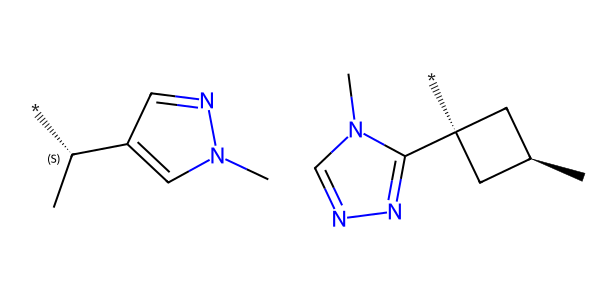

In [7]:
# fragment1 = "CCCC(=O)N1CCC[C@H]1-*"
fragment1 = 'C[C@H](-*)C1=CN(C)N=C1'
fragment2 = "C[C@H]1C[C@](-*)(C1)C1=NN=CN1C"

fragments = f'{fragment1}.{fragment2}'
linker_generation = [fragment1, fragment2]

dm.to_image(linker_generation)

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:588: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2024-07-24 00:33:29.806 | INFO     | safe.sample:_fragment_linking:393 - After sanitization, 500 / 500 (100.00 %)  generated molecules are valid !


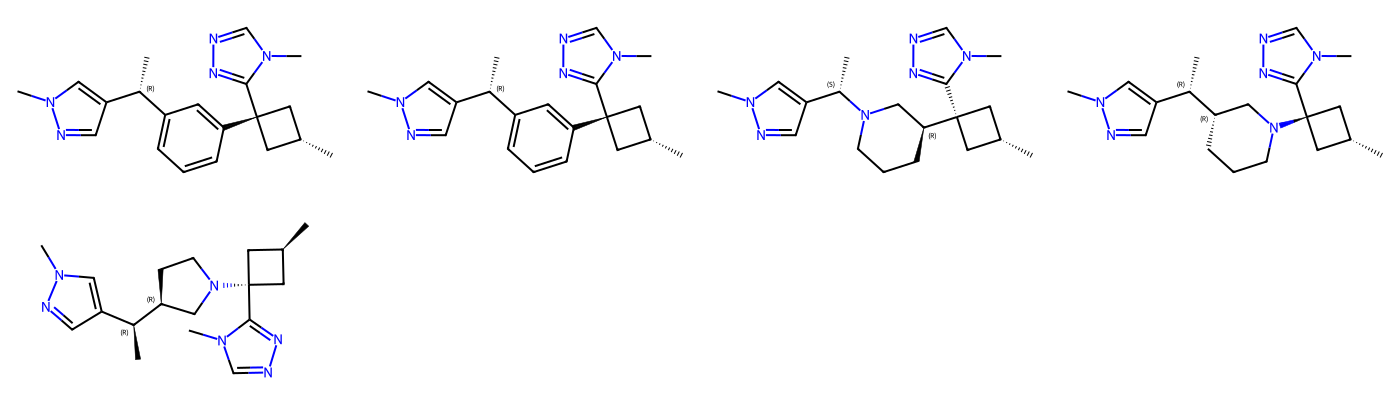

In [17]:
generated_smiles_linkers = designer.linker_generation(
    *linker_generation,
    n_samples_per_trial=500,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

dm.to_image(generated_smiles_linkers[:5], mol_size=(350, 200))

  0%|          | 0/1 [00:00<?, ?it/s]

2024-07-24 00:34:23.219 | INFO     | safe.sample:_fragment_linking:393 - After sanitization, 312 / 500 (62.40 %)  generated molecules are valid !


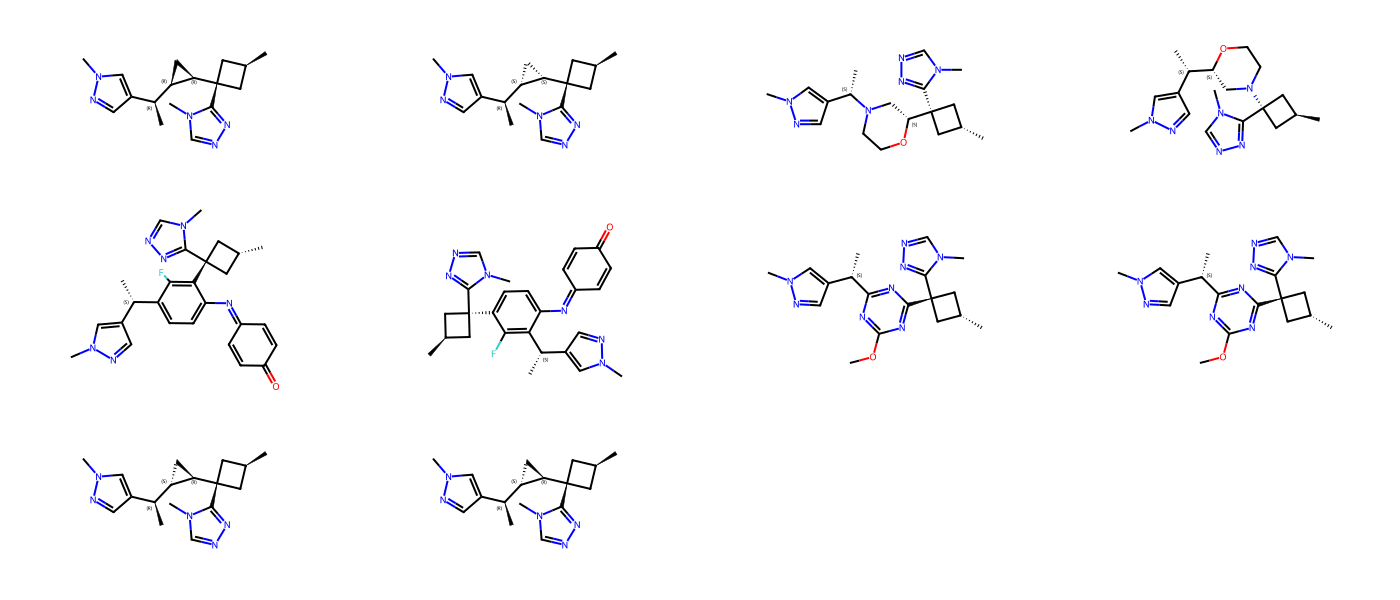

In [18]:
generated_smiles_scaffolds = designer.scaffold_morphing(
    side_chains=fragments,
    n_samples_per_trial=500,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

dm.to_image(generated_smiles_scaffolds[20:30], mol_size=(350, 200))

In [19]:
generated_smiles = generated_smiles_linkers + generated_smiles_scaffolds
generated_smiles.append('C[C@H](N1C=C(C=C(C2=CC=CC(=C2)[C@]2(C[C@H](C)C2)C2=NN=CN2C)C1=O)C(F)(F)F)C1=CN(C)N=C1') #add original compound
print(f'Total generated smiles: {len(generated_smiles)-1}')

Total generated smiles: 812


In [20]:
maindf = pd.DataFrame({'smiles': generated_smiles})
print(f'Total compounds before removing duplicates: {len(maindf)}')
PandasTools.AddMoleculeColumnToFrame(maindf,'smiles','molecule')
maindf['rot_bonds'] = maindf.molecule.apply(rdMolDescriptors.CalcNumRotatableBonds)
maindf['logP'] = maindf.molecule.apply(Crippen.MolLogP)
maindf['HBD'] = maindf.molecule.apply(rdMolDescriptors.CalcNumHBD)
maindf['mw'] = maindf.molecule.apply(rdMolDescriptors.CalcExactMolWt)
maindf['inchi'] = maindf.molecule.apply((Chem.MolToInchiKey))
maindf.drop_duplicates(subset='inchi', inplace=True)
print(f'Total compounds after removing duplicates: {len(maindf)}')

Total compounds before removing duplicates: 813
Total compounds after removing duplicates: 440


In [21]:
reos = uru.REOS()
reos.set_active_rule_sets(["Dundee"])
maindf[['rule_set','reos']] = [list(reos.process_mol(x)) for x in maindf.molecule]
uru.value_counts_df(maindf,"reos")

,reos,count
0,ok,370
1,imine,26
2,2-halo pyridine,8
3,nitro group,5
4,isolated alkene,4
5,diazo group,4
6,quaternary nitrogen,4
7,Thiocarbonyl group,3
8,charged oxygen or sulfur atoms,2
9,hydroquinone,2


In [22]:
filtered_df = maindf[
    (maindf['rot_bonds']<10) &
    (maindf['logP']<=5) &
    (maindf['HBD']<= 3) &
    (maindf['mw']<=600) &
    (maindf['reos']=='ok')
]
print (f'Total compounds after triage: {len(filtered_df)}')

Total compounds after triage: 362


In [23]:
ring_system_finder = uru.RingSystemFinder()
filtered_df = filtered_df.copy()
filtered_df['ring_systems'] = filtered_df.molecule.apply(ring_system_finder.find_ring_systems)
ring_list = chain(*filtered_df.ring_systems.values)
ring_series = pd.Series(ring_list)
ring_series.value_counts()
ring_df = pd.DataFrame(ring_series.value_counts()).reset_index()
ring_df.columns = ["SMILES","Count"]
mols2grid.display(ring_df,smiles_col="SMILES",subset=["img","Count"],selection=False)

MolGridWidget()

In [24]:
mols2grid.display(filtered_df,smiles_col="smiles",selection=False)

MolGridWidget()

In [25]:
def align(prbMol, refMol, prbCrippen=None, refCrippen=None, prbId=-1, refId=-1):
    """
    Aligns the probe molecule to the reference molecule using Crippen contributions.

    Parameters:
        prbMol: The probe molecule to be aligned.
        refMol: The reference molecule to align to.
        prbCrippen: Precomputed Crippen contributions for the probe molecule. Defaults to None.
        refCrippen: Precomputed Crippen contributions for the reference molecule. Defaults to None.
        prbId: Conformer ID for the probe molecule. Defaults to -1.
        refId: Conformer ID for the reference molecule. Defaults to -1.

    Returns:
        float: The RMSD value of the alignment.
    """
    if not isinstance(prbMol, Chem.Mol):
        raise TypeError("prbMol should be an RDKit Mol object.")
    if not isinstance(refMol, Chem.Mol):
        raise TypeError("refMol should be an RDKit Mol object.")
    
    if prbCrippen is None:
        prbCrippen = rdMolDescriptors._CalcCrippenContribs(prbMol)
    if refCrippen is None:
        refCrippen = rdMolDescriptors._CalcCrippenContribs(refMol)
    alignment = rdMolAlign.GetCrippenO3A(prbMol, refMol, prbCrippen, refCrippen, prbId, refId)
    return alignment.Align()

In [26]:
def generate_conformers(mol, num_conformers=50, prune_rms_thresh=0.2, random_seed=0xf00d, num_threads=0):
    """
    Generates conformers for a given molecule.

    Parameters:
        mol: The molecule for which to generate conformers, RDKit mol object.
        num_conformers: The number of conformers to generate. Defaults to 50.
        prune_rms_thresh: RMS threshold for pruning conformers. Defaults to 0.2.
        random_seed: Seed for reproducibility. Defaults to 0xf00d.
        num_threads: Number of threads to use. Defaults to 0. If set to zero, the max supported by the system will be used.

    Returns:
        The molecule with generated conformers.
    """
    if not isinstance(mol, Chem.Mol):
        raise TypeError("mol should be an RDKit Mol object.")
    
    mol = Chem.AddHs(mol)
    ps = AllChem.ETKDGv3()
    ps.randomSeed = random_seed
    ps.numThreads = num_threads
    ps.pruneRmsThresh = prune_rms_thresh
    ps.useRandomCoords = True
    AllChem.EmbedMultipleConfs(mol, num_conformers, ps)
    return mol

In [27]:

def calculate_3d_similarities(mol, probe_ligand, num_conformer=50):
    """
    Calculates the 3D shape and electrostatic potential (ESP) similarities between a molecule and a probe ligand.

    Parameters:
        mol: The molecule to compare. RDKit mol object.
        probe_ligand: The probe ligand to compare against.
        num_conformers: The number of conformers to generate for the molecule. Defaults to 50.

    Returns:
        pd.Series: A Pandas series containing the best shape similarity, best ESP similarity, and best total similarity scores.
    """
    best_shape_sim = 0 
    best_esp_sim = 0 
    best_total_sim = 0
    generated_ligand = generate_conformers(mol, num_conformer)
    for i in range(generated_ligand.GetNumConformers()):
        prbMol=deepcopy(probe_ligand)
        align(prbMol,generated_ligand,prbId=0,refId=i)
        shape_sim = GetShapeSim(prbMol, generated_ligand, prbCid=0, refCid=i)
        esp_sim = GetEspSim(prbMol, generated_ligand, prbCid=0, refCid=i)
        total_sim = shape_sim + esp_sim
        if total_sim>best_total_sim:
            best_total_sim = total_sim
            best_shape_sim = shape_sim
            best_esp_sim = esp_sim
    return pd.Series([best_shape_sim, best_esp_sim, best_total_sim])

In [28]:
filtered_df = filtered_df.copy()
filtered_df[['shape_sim', 'esp_sim', 'total_sim']] = filtered_df.molecule.progress_apply(calculate_3d_similarities, args=(ligand,70))

100%|██████████| 362/362 [14:22<00:00,  2.38s/it]   


In [100]:

filtered_df.sort_values(by='total_sim', ascending=False, inplace=True)

In [51]:
def calculate_3d_similarities_single(mol, probe_ligand, num_conformer=50):
    """
    Calculates the 3D shape and electrostatic potential (ESP) similarities for each conformer of a molecule 
    against a probe ligand, and identifies the conformers with the highest ESP similarity and total similarity.

    Parameters:
        mol: The molecule to compare.
        probe_ligand: The probe ligand to compare against.
        num_conformers: The number of conformers to generate for the molecule. Defaults to 50.

    Returns:
        A tuple containing:
            - DataFrame with similarities for each conformer.
            - The molecule with generated conformers.
            - The conformer ID with the highest ESP similarity.
            - The conformer ID with the highest total similarity.
    """
     
    best_shape_sim = 0 
    best_esp_sim = 0 
    best_total_sim = 0
    generated_ligand = generate_conformers(mol, num_conformer)
    all_sims = {'shape_sim':[], 'conformer':[], 'esp_sim': [], 'total_sim':[] }

    for i in range(generated_ligand.GetNumConformers()):
        prbMol=deepcopy(probe_ligand)
        align(prbMol,generated_ligand,prbId=0,refId=i)
        shape_sim = GetShapeSim(prbMol, generated_ligand, prbCid=0, refCid=i)
        esp_sim = GetEspSim(prbMol, generated_ligand, prbCid=0, refCid=i)
        total_sim = shape_sim + esp_sim
        all_sims['conformer'].append(i)
        all_sims['shape_sim'].append(shape_sim)
        all_sims['esp_sim'].append(esp_sim)
        all_sims['total_sim'].append(total_sim)
        
    df = pd.DataFrame.from_dict(all_sims)
    max_espsim_confid = int(df.sort_values('esp_sim', ascending=False)['conformer'].iloc[0])
    max_total_sim_confid = int(df.sort_values('total_sim', ascending=False)['conformer'].iloc[0])
    return df, generated_ligand, max_espsim_confid, max_total_sim_confid


In [91]:
def draw_superimposed_new(probe_mol, df, rdkit_mol_column = 'molecule', probe_id=0, width=1000, height=600, grid_size=(2,3)):
    """
    Draws the superimposed 3D structures of a probe molecule and a reference molecule using py3Dmol.

    Parameters:
        probe_mol: The probe molecule to be superimposed. RDKit Mol object.
        df: The dataframe that contains 3D similarities scores.
        rdkit_mol_column: Column name in df that contains the rdkit mol object. Defaults to 'molecule'
        ref_mol: The reference molecule to align to. RDKit Mol object.
        probe_id: The conformer ID of the probe molecule.
        ref_id: The conformer ID of the reference molecule.
        width: The width of the viewer window. Defaults to 600.
        height: The height of the viewer window. Defaults to 400.

    Returns:
        The py3Dmol viewer with the superimposed molecules displayed.
    """
    view = py3Dmol.view(width=width, height=height, linked=False, viewergrid=grid_size)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            mol_position_on_df = i*grid_size[1]+j
            index_to_use = df.index[mol_position_on_df]

            aa, ref_mol, ref_id,bb = calculate_3d_similarities_single(df[rdkit_mol_column].loc[index_to_use], ligand, num_conformer=70)
    
            prbMol=deepcopy(probe_mol)
            align(prbMol,ref_mol,prbId=probe_id,refId=ref_id)
    
            view.addModel(Chem.MolToMolBlock(prbMol), 'mol', viewer=(i,j))
            view.addModel(Chem.MolToMolBlock(ref_mol, confId=ref_id), 'mol', viewer=(i,j))
            view.setStyle({'stick':{}}, viewer=(i,j))
            view.setStyle({'model':0},{'stick': {'colorscheme': 'greenCarbon'}}, viewer=(i,j))
    view.zoomTo()
    return view.render()
# top_comp_df, top_selected_mol, top_max_espsim_confid, top_max_total_sim_confid = calculate_3d_similarities_single(filtered_df['molecule'].loc[top_scoring_index], ligand, num_conformer=70)

In [99]:
image_grid_size = (2,3)
draw_superimposed_new(ligand, filtered_df, rdkit_mol_column = 'molecule', probe_id=0, width=1000, height=600, grid_size=image_grid_size)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [90]:
mols2grid.display(filtered_df,smiles_col="smiles",selection=False, size=(300, 150), n_items_per_page=12)

MolGridWidget()